In [1]:
# imports needed and logging
import gzip
import gensim 
import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)
from sklearn.model_selection import train_test_split

In [2]:
import nltk
from nltk.corpus import stopwords  #stopwords
from nltk.stem import WordNetLemmatizer  
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
#nltk.download()
stop_words=set(nltk.corpus.stopwords.words('english'))

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
import numpy as np
import pandas as pd

# Read the file
data has ~6000 reviews of laptops on Amazon <br> basic EDA

In [5]:
laptop = pd.read_excel("ML_project_dataset_final.xlsx")

In [6]:
laptop.columns

Index(['ProductName', 'ProductPrice', 'Rate', 'Review', 'Summary',
       'Sentiment'],
      dtype='object')

In [7]:
#Drop the product price column as it is not required and contains some garbage values
laptop = laptop.drop(["ProductPrice"], axis=1)

In [8]:
laptop.tail()

,ProductName,Rate,Review,Summary,Sentiment
6864,ASUS TUF Gaming A17 with 90Whr Battery Ryzen 5...,5,Best in the market!,go for it no doubt,negative
6865,MSI GF63 Thin Core i5 11th Gen - (8 GB/512 GB ...,1,Absolute rubbish!,battery problem,negative
6866,Lenovo IdeaPad Gaming Core i5 11th Gen - (8 GB...,4,Pretty good,everything was good but the sound bit lower,negative
6867,Lenovo IdeaPad Gaming Core i5 11th Gen - (8 GB...,2,Bad quality,value for money 44k battery backup very poor p...,negative
6868,Lenovo IdeaPad Gaming Core i5 11th Gen - (8 GB...,5,Terrific,everyone saying that its worth of money but ba...,negative


In [9]:
len(laptop[laptop.Sentiment == "positive"])

4346

In [10]:
len(laptop[laptop.Sentiment == "negative"])

1934

In [11]:
#Data is imbalanced?

In [12]:
len(laptop[laptop.Sentiment == "neutral"])

588

# PART 1: TOPIC MODELLING USING LDA



# Step 1: Data Pre-processing
Converting the text to lowercase.<br>
Apply lemmatization to the words so that the root words of all derived words are used. <br>
Remove stop-words <br>
Remove words with lengths less than 2 

In [13]:
#Checking the stop words we got from nltk library
stop_words = {'themselves', 'theirs', 'as', 'yourselves', 'mightn', 'll', 'hers', 'about', "shouldn't", "isn't", 'doing', "needn't", 'needn', 'y', 'himself', 'when', "didn't", 'haven', 'our', 'had', 'were', 'which', 'yourself', 'can', 'most', 'or', "couldn't", 'be', 'too', 'above', 'before', 'more', 'o', "you're", 'we', 'some', 'no', 'isn', 'my', 'after', 'below', 'nor', 'through', 'where', 'ours', 'in', 'its', 'yours', 'them', 've', "mightn't", 'wasn', "should've", 'hadn', 'wouldn', 'who', 'have', 'so', 'there', 'he', 'here', 'while', 'these', 'is', 'd', 'her', 'it', 'from', 'same', 'his', 'such', 'am', 'having', 'a', 'by', 'during', "weren't", "she's", 'an', 'off', 'doesn', 'any', 'out', 'but', "doesn't", 'this', 'because', 'their', 'myself', "hadn't", 'and', 'under', 'that', 'both', 'aren', "that'll", 'shan', 'hasn', 'weren', 'been', 'shouldn', 'other', "wouldn't", 'how', "you'll", "hasn't", 'few', 'once', 'mustn', 'him', "it's", "you'd", 'to', 't', 'each', 'very', 'why', 're', 'further', 'those', 'will', 'into', 'me', 'all', 'then', 'ourselves', 'm', "aren't", 'they', 'didn', 'itself', 'your', 'won', 'ain', "mustn't", 'being', 'not', 'did', "won't", 'of', 'couldn', 'should', "don't", 'you', 'with', 'do', 'she', 'the', 'at', 'what', 'now', 'does', 'herself', 'between', 'are', 'if', 'was', "wasn't", 'ma', "haven't", 'i', 'until', "shan't", 'than', 'whom', 'again', 'has', "you've", 'on'}
print(stop_words)

{'into', 'didn', 'who', 'will', "you'd", 'had', "mightn't", 'm', 'these', 'him', 'that', 'each', 'y', 'o', 'themselves', 'do', 'further', 'mightn', "couldn't", 'again', 'hadn', 'through', 'mustn', 'theirs', 'both', 'where', 'what', 'weren', 'once', 'does', 'by', 'myself', 'is', 'under', 'a', 'ours', 'very', 'won', 'has', 'nor', "aren't", 'needn', "you're", 'here', 'been', 'some', 'isn', 'now', "hadn't", 'out', 'your', 've', "hasn't", 'having', 'but', 'until', "weren't", 'ma', 'there', "it's", 'and', 'yourselves', 'his', "should've", "haven't", 'hers', 'my', 'being', 'their', "she's", 'me', 'you', 'such', 'wasn', 're', 'below', 'haven', 'then', 'was', 'off', 'she', 'll', 'our', 'of', 'i', 'were', 'those', 'not', 'before', 'we', 'other', 'as', "you'll", 'be', "wouldn't", 'he', "didn't", 'her', 'an', 't', 'doing', 'above', 'this', 'most', 'the', 'wouldn', 'doesn', "you've", 'have', 'with', 'they', 'at', 'how', 'after', 'so', 'aren', 'all', 'herself', 'on', 'shan', 'because', "shouldn't", 

In [14]:
##Define a function to pre-process the data
def clean_text(review):
    le=WordNetLemmatizer() ##Lemmatize
    word_tokens=word_tokenize(review) ##Splits given sentence into words i.e. tokenize
    tokens=[le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w)>1] #Create tokens
    cleaned_review=" ".join(tokens)
    return cleaned_review

In [15]:
laptop['cleaned_review']=laptop['Summary'].apply(clean_text)

In [16]:
laptop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6869 entries, 0 to 6868
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ProductName     6869 non-null   object
 1   Rate            6869 non-null   int64 
 2   Review          6869 non-null   object
 3   Summary         6869 non-null   object
 4   Sentiment       6869 non-null   object
 5   cleaned_review  6869 non-null   object
dtypes: int64(1), object(5)
memory usage: 322.1+ KB


In [17]:
laptop.head()

,ProductName,Rate,Review,Summary,Sentiment,cleaned_review
0,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Horrible,poor delivery service denied to follow open bo...,negative,poor delivery service denied follow open box p...
1,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Worthless,worst product ever seen,negative,worst product ever seen
2,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Utterly Disappointed,display not working yet,negative,display working yet
3,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Useless product,got it for just 41500 but all excitment went i...,negative,got for just 41500 excitment went vain receive...
4,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Worthless,i brought this laptop for 51490 offer price wa...,negative,brought laptop for 51490 offer price 53990 le ...


# Step 2: Convert each word to a vector form
For topic modeling, we would use CountVectorizer <br>

In [18]:
# initialise the count vectorizer
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2))

In [19]:
#Initialize a list (for each word to be added in a vectors list)
vectors = []

In [20]:
# join the processed data to be vectorised
for index, row in laptop['cleaned_review'].to_frame().iterrows():
    vectors.append(row['cleaned_review'])

In [21]:
#Now transform each word to a vector form
vectorised = vectorizer.fit_transform(vectors)

In [22]:
type(vectorised)

scipy.sparse._csr.csr_matrix

In [23]:
print(vectorised)
##INTERPRETATION: 1st digit in the tuple is the index of the review / row number, 
#the second number in the tuple is the number form of words from vocabulary 
#and the second column is the occurance of that particular word
##For example
##In row 0 i.e. review 1st, a word whose vector format is 16373 occurs once in the review, 
##a word whose vector format is 19297 occurs twice in the review

  (0, 16122)	1
  (0, 5564)	1
  (0, 18994)	2
  (0, 5623)	1
  (0, 7806)	1
  (0, 15005)	1
  (0, 3438)	1
  (0, 16113)	1
  (0, 11224)	1
  (0, 17889)	1
  (0, 16753)	2
  (0, 17792)	2
  (0, 18923)	1
  (0, 14151)	1
  (0, 10524)	2
  (0, 13171)	1
  (0, 21229)	1
  (0, 14153)	1
  (0, 85)	1
  (0, 7812)	2
  (0, 6112)	1
  (0, 6675)	1
  (0, 17123)	1
  (0, 5010)	1
  (0, 1406)	1
  :	:
  (6868, 28)	1
  (6868, 2833)	1
  (6868, 5764)	1
  (6868, 23028)	1
  (6868, 18844)	1
  (6868, 16076)	1
  (6868, 13681)	1
  (6868, 23044)	1
  (6868, 12407)	1
  (6868, 6796)	1
  (6868, 18639)	1
  (6868, 22198)	1
  (6868, 6533)	1
  (6868, 9807)	1
  (6868, 6801)	1
  (6868, 18644)	1
  (6868, 16632)	1
  (6868, 16096)	1
  (6868, 22199)	1
  (6868, 6534)	1
  (6868, 5780)	1
  (6868, 14790)	1
  (6868, 9808)	1
  (6868, 37)	1
  (6868, 12411)	1


In [24]:
vectorised.get_shape() ##Just to check the shape, we have 6869 reviews as in our dataset

(6869, 23225)

# Step 3: Perform LDA 
#We perform LDA on the vectorized reviews and find out topics

In [25]:
# initisalise LDA Model
lda_model = LatentDirichletAllocation(n_components = 7, # number of topics
                                  random_state = 0,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

In [26]:
# Fit the model to our vectorised
output = lda_model.fit_transform(vectorised)

In [27]:
#Shape = No of reviews x no of clusters
output.shape

(6869, 7)

In [28]:
#The above fit would cluster the reviews in 10 clusters called 'topics'
#A document or a review is a mix of multiple topics
#We need to find out what is the dominant topic of each review
#First of all lets create columns for each topic & dominant topic in our dataframe
topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

In [29]:
# Create a dataframe with these 10 columns
laptop_reviews_topic = pd.DataFrame(np.round(output, 4), columns = topic_names)

In [30]:
# Find out the dominant topic for each review
dominant_topic = (np.argmax(laptop_reviews_topic.values, axis=1)+1)

# Add column to dataframe
laptop_reviews_topic['Dominant_topic'] = dominant_topic

In [31]:
#Check the dataframe
laptop_reviews_topic

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Dominant_topic
0,0.0020,0.0020,0.0020,0.0020,0.0020,0.0020,0.9881,7
1,0.0179,0.0179,0.0179,0.8927,0.0179,0.0179,0.0179,4
2,0.0238,0.0239,0.0238,0.8569,0.0239,0.0239,0.0239,4
3,0.0042,0.0042,0.0042,0.0042,0.9748,0.0042,0.0042,5
4,0.0014,0.0014,0.9916,0.0014,0.0014,0.0014,0.0014,3
...,...,...,...,...,...,...,...,...
6864,0.0238,0.0239,0.0239,0.0238,0.8569,0.0239,0.0238,5
6865,0.0358,0.0358,0.0357,0.7852,0.0358,0.0358,0.0358,4
6866,0.0143,0.0143,0.0143,0.0143,0.0143,0.0143,0.9141,7
6867,0.0051,0.8338,0.1407,0.0051,0.0051,0.0051,0.0051,2


In [32]:
# join this to original dataframes with mapping the index
laptop = pd.merge(laptop, laptop_reviews_topic, left_index = True, right_index = True)

In [33]:
display(laptop.head(25))

##Thus, we got which review is dominated by which topic. 
#The next step would be to find out what those topics are related to
#That is we see what topic a review belongs to

,ProductName,Rate,Review,Summary,Sentiment,cleaned_review,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Dominant_topic
0,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Horrible,poor delivery service denied to follow open bo...,negative,poor delivery service denied follow open box p...,0.0020,0.0020,0.0020,0.0020,0.0020,0.0020,0.9881,7
1,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Worthless,worst product ever seen,negative,worst product ever seen,0.0179,0.0179,0.0179,0.8927,0.0179,0.0179,0.0179,4
2,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Utterly Disappointed,display not working yet,negative,display working yet,0.0238,0.0239,0.0238,0.8569,0.0239,0.0239,0.0239,4
3,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Useless product,got it for just 41500 but all excitment went i...,negative,got for just 41500 excitment went vain receive...,0.0042,0.0042,0.0042,0.0042,0.9748,0.0042,0.0042,5
4,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Worthless,i brought this laptop for 51490 offer price wa...,negative,brought laptop for 51490 offer price 53990 le ...,0.0014,0.0014,0.9916,0.0014,0.0014,0.0014,0.0014,3
5,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Horrible,u camt get a worse deal at this price just sav...,negative,camt get worse deal price just save monry go f...,0.0031,0.0031,0.0031,0.0031,0.9813,0.0031,0.0031,5
6,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Hated it!,charging issue and current issue,negative,charging issue current issue,0.0179,0.0179,0.0179,0.0179,0.0179,0.0179,0.8927,7
7,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Horrible,total worst product,negative,total worst product,0.0238,0.0238,0.0238,0.8570,0.0239,0.0238,0.0238,4
8,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Useless product,dont buy because not good,negative,dont buy good,0.0239,0.0239,0.0239,0.0240,0.0239,0.8566,0.0239,6
9,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Waste of money!,poor battery,negative,poor battery,0.7854,0.0358,0.0358,0.0358,0.0358,0.0357,0.0358,1


# Step4: Find out keywords related to each topic

In [34]:
#.components gives the component of each cluster (i.e. topic) and a relevance score
#If we arrange them in descending order of relevance score, we would be able to recongnize which keywords has 
#the highest relevance with a particular topic and hence we would be able to identify the approx topic
lda_model.components_.shape

#we can verify it from the shape of components, it is 10x23576 i.e no of clusters (topics) x no of words in the vocab

(7, 23225)

In [35]:
#Get the components
laptop_topic_keywords = pd.DataFrame(lda_model.components_)

In [36]:
# Assign Column and Index
laptop_topic_keywords.columns = vectorizer.get_feature_names_out()
laptop_topic_keywords.index = topic_names

In [37]:
#Create dataframe for topic number
laptop_topic_no = pd.DataFrame(laptop_topic_keywords.idxmax()) #return index of keyword with maximum component

#Create dataframe for relevance score
laptop_scores = pd.DataFrame(laptop_topic_keywords.max()) #return the keyword with maximum component

In [38]:
# Create a dataframe to combine above DFs
topic_relevance_scores = pd.merge(laptop_topic_no, laptop_scores, left_index=True, right_index=True)
topic_relevance_scores.columns = ['topic', 'relevance_score']

display(topic_relevance_scores)

,topic,relevance_score
0100,Topic5,3.142857
0100 le,Topic5,3.142857
10,Topic1,22.441146
10 100,Topic7,4.142857
10 15,Topic2,3.142862
...,...,...
zero people,Topic7,1.142805
zero withing,Topic5,3.142857
zoom,Topic6,8.142857
zoom using,Topic6,3.142857


In [39]:
#This dataframe containss each word in the vocabulary and the topic it belongs to
#A review is a mixture of such words, hence it will be a mixture of topics
#Now, for each topic, I would order our dataframe in descending order and select the keywords with the highest score.

In [40]:
for i in range(len(topic_names)):
    topic_i = topic_relevance_scores.loc[topic_relevance_scores['topic'] == 'Topic{}'.format(i+1)]
    topic_i_sorted = topic_i.sort_values('relevance_score', ascending = False)
    display(topic_i_sorted.head(10))

,topic,relevance_score
battery,Topic1,392.234363
best,Topic1,341.519614
backup,Topic1,277.177650
battery backup,Topic1,252.261289
price,Topic1,231.280304
bad,Topic1,135.788081
range,Topic1,124.640751
best laptop,Topic1,123.724788
price range,Topic1,111.433114
great,Topic1,100.302710


,topic,relevance_score
for,Topic2,744.672751
gaming,Topic2,307.930060
only,Topic2,215.460354
display,Topic2,179.201200
hour,Topic2,159.768957
game,Topic2,110.347018
one,Topic2,108.363121
just,Topic2,104.603764
for gaming,Topic2,96.500954
laptop for,Topic2,95.345854


,topic,relevance_score
money,Topic3,426.560058
for money,Topic3,403.199667
value,Topic3,392.225394
value for,Topic3,370.601124
beast,Topic3,77.710530
ram,Topic3,60.250201
big,Topic3,54.148151
come,Topic3,42.855214
best value,Topic3,41.108122
big big,Topic3,39.142857


,topic,relevance_score
product,Topic4,489.693544
nice,Topic4,285.218010
nice product,Topic4,165.212283
worst,Topic4,105.119283
dont,Topic4,98.311760
waste,Topic4,96.164032
thing,Topic4,86.571301
ok,Topic4,74.761682
fast,Topic4,71.375241
flipkart,Topic4,66.824940


,topic,relevance_score
go,Topic5,120.314958
go for,Topic5,101.905195
using,Topic5,81.356392
problem,Topic5,77.071477
month,Topic5,73.402227
much,Topic5,64.506725
asus,Topic5,50.668059
service,Topic5,47.725631
power,Topic5,46.527825
system,Topic5,36.383088


,topic,relevance_score
laptop,Topic6,618.536585
buy,Topic6,151.749664
excellent,Topic6,111.344679
day,Topic6,88.155652
wifi,Topic6,56.150576
happy,Topic6,42.982692
love,Topic6,39.772582
excellent product,Topic6,36.142441
15,Topic6,34.038442
looking,Topic6,33.349982


,topic,relevance_score
good,Topic7,1153.906410
performance,Topic7,329.266938
good product,Topic7,225.434204
quality,Topic7,176.808205
also,Topic7,142.084733
awesome,Topic7,128.809044
issue,Topic7,121.816462
sound,Topic7,100.871204
good laptop,Topic7,95.801056
low,Topic7,93.179631


In [41]:
## Next, lets map keywords and broad topics and add it to our dataframe

In [42]:
##Add one column to dataframe 'laptop' mapping the dominant topic name
#Topic 1: Battery life
#Topic 2: Display
#Topic 3: Value for money
#Topic 4: Overall product
#Topic 5: Service
#Topic 6: Wifi
#Topic 7: Quality & Performance

In [43]:
# Insights for Topic Modelling

# Map the topic names to the dominant topics

import pandas as pd

equiv = {1: 'Battery life', 2: 'Display', 3: 'Value for money', 4: 'Overall product', 5: 'Service', 6: 'Wifi', 7: 'Quality & Performance'}
#laptop = laptop.DataFrame( {"Dominant_topic": [1, 2, 3, 4, 5, 6, 7]} )
laptop["Dominant Topic Name"] = laptop["Dominant_topic"].map(equiv)

laptop

,ProductName,Rate,Review,Summary,Sentiment,cleaned_review,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Dominant_topic,Dominant Topic Name
0,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Horrible,poor delivery service denied to follow open bo...,negative,poor delivery service denied follow open box p...,0.0020,0.0020,0.0020,0.0020,0.0020,0.0020,0.9881,7,Quality & Performance
1,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Worthless,worst product ever seen,negative,worst product ever seen,0.0179,0.0179,0.0179,0.8927,0.0179,0.0179,0.0179,4,Overall product
2,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Utterly Disappointed,display not working yet,negative,display working yet,0.0238,0.0239,0.0238,0.8569,0.0239,0.0239,0.0239,4,Overall product
3,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Useless product,got it for just 41500 but all excitment went i...,negative,got for just 41500 excitment went vain receive...,0.0042,0.0042,0.0042,0.0042,0.9748,0.0042,0.0042,5,Service
4,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/5...,1,Worthless,i brought this laptop for 51490 offer price wa...,negative,brought laptop for 51490 offer price 53990 le ...,0.0014,0.0014,0.9916,0.0014,0.0014,0.0014,0.0014,3,Value for money
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6864,ASUS TUF Gaming A17 with 90Whr Battery Ryzen 5...,5,Best in the market!,go for it no doubt,negative,go for doubt,0.0238,0.0239,0.0239,0.0238,0.8569,0.0239,0.0238,5,Service
6865,MSI GF63 Thin Core i5 11th Gen - (8 GB/512 GB ...,1,Absolute rubbish!,battery problem,negative,battery problem,0.0358,0.0358,0.0357,0.7852,0.0358,0.0358,0.0358,4,Overall product
6866,Lenovo IdeaPad Gaming Core i5 11th Gen - (8 GB...,4,Pretty good,everything was good but the sound bit lower,negative,everything good sound bit lower,0.0143,0.0143,0.0143,0.0143,0.0143,0.0143,0.9141,7,Quality & Performance
6867,Lenovo IdeaPad Gaming Core i5 11th Gen - (8 GB...,2,Bad quality,value for money 44k battery backup very poor p...,negative,value for money 44k battery backup poor perfor...,0.0051,0.8338,0.1407,0.0051,0.0051,0.0051,0.0051,2,Display


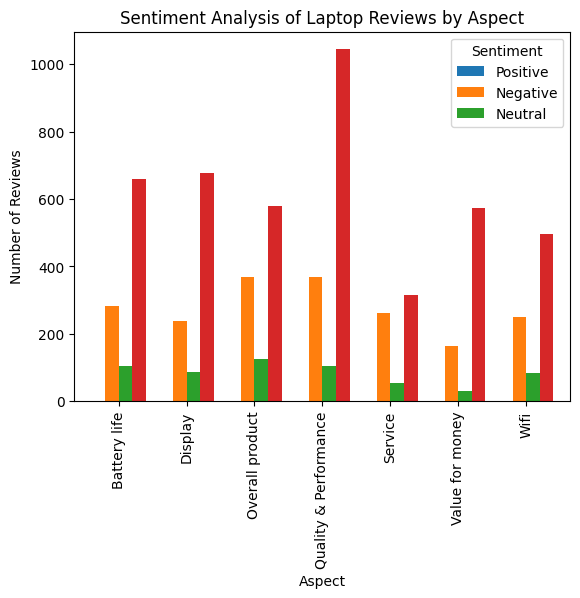

In [45]:
# Plotting the number of positive, negative, and neutral reviews for each of the 7 aspects

import pandas as pd
import matplotlib.pyplot as plt

# Group the dataset by aspect and sentiment score
grouped = laptop.groupby(['Dominant Topic Name', 'Sentiment'])

# Count the number of reviews for each aspect and sentiment score
counts = grouped.size().unstack(fill_value=0)

# Plot the counts for each aspect and sentiment score
counts.plot(kind='bar', width=0.8)

# Set the plot title and labels
plt.title('Sentiment Analysis of Laptop Reviews by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Number of Reviews')

# Set the x-axis labels
x_labels = counts.index
plt.xticks(range(len(x_labels)), x_labels)

# Add legend
plt.legend(title='Sentiment', loc='upper right', labels=['Positive', 'Negative', 'Neutral'])

# Display the plot
plt.show()